## Load features dataset

In [16]:
import numpy as np
import pandas as pd
import os
import re
import joblib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
features_folder = '/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Dataset/1_Processed/CSI_Features/2-seconds-top-features'
features_list = [f for f in os.listdir(features_folder) if f.endswith('.csv')]

dfs = []
for file_name in features_list:
    # We will use data of day 1 and 2 for cross validation
    match = re.search(r"csi-top-feats-d(\d+)-(\d+)", file_name)
    if match:
      print(file_name)
      label = match.group(2)
      print("label:", label)
      file_path = os.path.join(features_folder, file_name)
      df = pd.read_csv(file_path)
      df["label"] = int(label)
      dfs.append(df)
print("Number of dataframes loaded: ", len(dfs))

csi-top-feats-d1-0.csv
label: 0
csi-top-feats-d1-1.csv
label: 1
csi-top-feats-d1-2.csv
label: 2
csi-top-feats-d1-3.csv
label: 3
csi-top-feats-d1-4.csv
label: 4
csi-top-feats-d1-5.csv
label: 5
csi-top-feats-d2-0.csv
label: 0
csi-top-feats-d2-1.csv
label: 1
csi-top-feats-d2-2.csv
label: 2
csi-top-feats-d2-3.csv
label: 3
csi-top-feats-d2-4.csv
label: 4
csi-top-feats-d2-5.csv
label: 5
csi-top-feats-d3-0.csv
label: 0
csi-top-feats-d3-1.csv
label: 1
csi-top-feats-d3-2.csv
label: 2
csi-top-feats-d3-3.csv
label: 3
csi-top-feats-d3-4.csv
label: 4
csi-top-feats-d3-5.csv
label: 5
Number of dataframes loaded:  18


## Split and stratify

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer

In [5]:
df_fea_all = pd.DataFrame()

for i in range(len(dfs)):
    df_fea_all = pd.concat([df_fea_all, dfs[i]], axis=0)

df_fea_all.reset_index(drop=True)


,Unnamed: 0,std_subcarrier_0,iqr_subcarrier_0,std_subcarrier_1,iqr_subcarrier_1,std_subcarrier_2,iqr_subcarrier_2,std_subcarrier_3,iqr_subcarrier_3,std_subcarrier_4,...,adj_subcarrier_42,adj_subcarrier_43,adj_subcarrier_44,adj_subcarrier_45,adj_subcarrier_46,adj_subcarrier_47,adj_subcarrier_48,adj_subcarrier_49,rss_std,label
0,0,2.458781,3.992281,2.175019,3.263909,2.607608,4.054666,2.447273,3.419030,2.311035,...,7.725777,4.387893,4.157481,2.961773,3.508334,3.186696,3.576259,3.650341,1.086784,0
1,1,1.982891,2.323331,1.839736,2.128634,2.058917,2.097408,1.971215,2.614072,1.897029,...,6.981031,4.177062,4.234196,3.672567,3.835890,4.142555,4.031667,4.095948,1.969365,0
2,2,2.532899,3.433383,2.301174,3.429699,2.570546,3.587336,2.700475,3.569633,2.700367,...,7.053560,4.864779,4.436664,4.104615,4.844086,5.216937,4.654624,4.370355,2.295191,0
3,3,1.386501,1.901993,1.583156,2.390205,1.771073,2.487773,2.214081,2.122840,2.353476,...,7.767771,4.261174,4.017492,3.862723,4.494754,4.508927,3.997518,3.368922,2.214221,0
4,4,1.468549,2.091804,1.342521,2.044884,1.473380,2.035797,1.898732,1.908809,1.256840,...,8.114839,4.819547,4.449275,3.433007,4.036137,3.518238,3.760217,3.295091,1.898921,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3565,159,9.831218,6.946445,9.039429,6.507089,9.643183,6.218597,9.948644,5.932807,9.201126,...,6.974629,5.008503,5.316596,4.957762,5.448862,5.030393,4.529632,3.482084,2.506073,5
3566,160,3.000602,4.664857,2.546410,3.318601,3.196587,4.396880,2.930711,3.664461,2.673806,...,7.081345,4.523281,4.170807,4.370057,4.733311,4.558936,4.076752,2.999328,1.857680,5
3567,161,1.928810,2.794866,2.333736,3.176323,2.046384,3.274217,2.179252,3.103789,2.111282,...,8.167755,5.119288,4.066608,3.549240,3.239923,3.351568,2.953703,2.492684,2.122351,5
3568,162,2.217180,2.169366,2.028640,2.451481,2.134763,2.464533,2.183415,2.683262,2.145448,...,7.076097,4.661318,4.493716,4.161460,4.593099,4.566673,4.027329,2.952847,2.767743,5


In [6]:
# Combine all dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)

# Split the combined dataframe into features (X) and labels (Y)
X = combined_df.drop(columns=["label"])
Y = combined_df["label"]

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (3570, 154)
Shape of Y: (3570,)


In [7]:
# set k for k-hold cross-validation
k = 7

X = df_fea_all.drop('label', axis=1)
y = df_fea_all['label']

X = X.reset_index()
X = X.drop('index', axis = 1)
y = y.reset_index()
y = y.drop('index', axis = 1)

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
X = pd.DataFrame(X)

skf = StratifiedKFold(n_splits=k)

train_index = [[] for _ in range(k)]
test_index = [[] for _ in range(k)]

n = 0
for tra_idx, tes_idx in skf.split(X,y):

    print('##### Stratified k-fold',n+1,'#####')
    print("TRAIN: ",len(tra_idx))
    print("TEST: ",len(tes_idx))

    train_index[n] = tra_idx
    test_index[n] = tes_idx

    n += 1

##### Stratified k-fold 1 #####
TRAIN:  3060
TEST:  510
##### Stratified k-fold 2 #####
TRAIN:  3060
TEST:  510
##### Stratified k-fold 3 #####
TRAIN:  3060
TEST:  510
##### Stratified k-fold 4 #####
TRAIN:  3060
TEST:  510
##### Stratified k-fold 5 #####
TRAIN:  3060
TEST:  510
##### Stratified k-fold 6 #####
TRAIN:  3060
TEST:  510
##### Stratified k-fold 7 #####
TRAIN:  3060
TEST:  510


## DNNR Training

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [9]:
early_stopping =  EarlyStopping(
                            monitor='val_mae',
                            min_delta=0,
                            patience=100,
                            verbose=1,
                            mode='auto')

In [10]:
def compare_TV(history, train_met, val_met):
    acc = history.history[train_met]
    val_acc = history.history[val_met]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo' ,label = 'training '+train_met)
    plt.plot(epochs, val_acc, 'b' , label= 'validation '+val_met)
    plt.title('Training and Validation metrics')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4.7776 - mae: 1.6403 - val_loss: 1.4439 - val_mae: 0.9294
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.5906 - mae: 0.9832 - val_loss: 1.1656 - val_mae: 0.8217
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.1706 - mae: 0.8276 - val_loss: 1.0530 - val_mae: 0.7771
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9841 - mae: 0.7435 - val_loss: 0.9406 - val_mae: 0.7403
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8837 - mae: 0.7163 - val_loss: 0.8277 - val_mae: 0.6847
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7244 - mae: 0.6392 - val_loss: 0.9242 - val_mae: 0.7234
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7651 - mae: 0.6574 - val_loss: 0.8798 - val_mae: 0.7011
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6625 - mae: 0.6075 - val_loss: 0.8760 - val_mae: 0.7028
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/

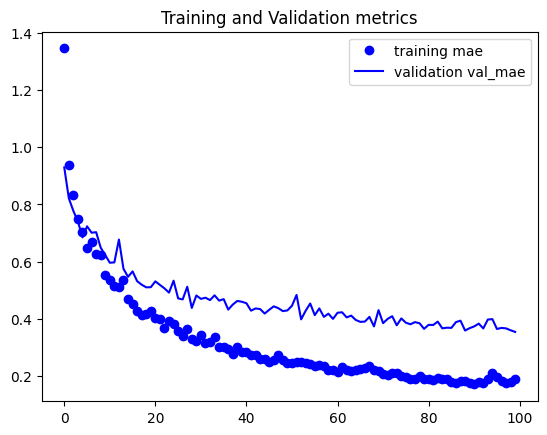

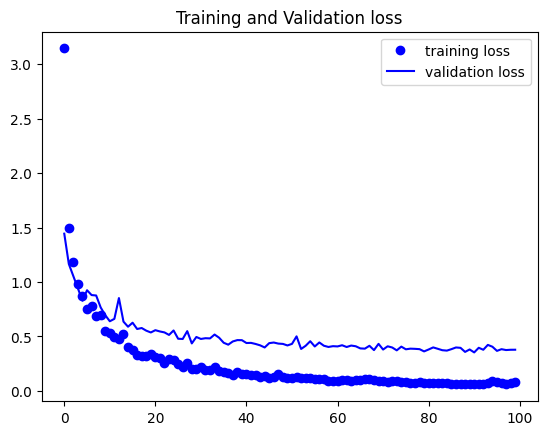

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 1 completed with MAE: 0.5683644711971283
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.8813 - mae: 1.9370 - val_loss: 1.8651 - val_mae: 1.0830
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.0709 - mae: 1.1216 - val_loss: 1.4689 - val_mae: 0.9968
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5952 - mae: 0.9900 - val_loss: 1.1226 - val_mae: 0.8257
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1392 - mae: 0.8159 - val_loss: 1.0524 - val_mae: 0.7948
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9069 - mae: 0.7325 - val_loss: 0.9716 - val_mae: 0.7747
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9304 - mae: 0.7259 - val_loss: 1.0186 - val_mae: 0.7774
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.7899 - mae: 0.6670 - val_loss: 0.9335 - val_mae: 0.7310
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.6780 - mae: 0.6147 - val_loss: 0.8634 - val_mae: 0.7045
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 

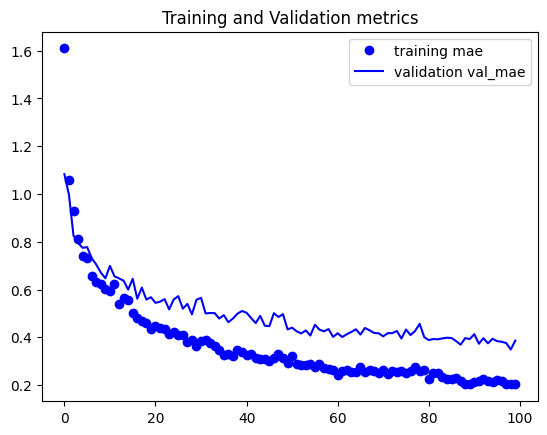

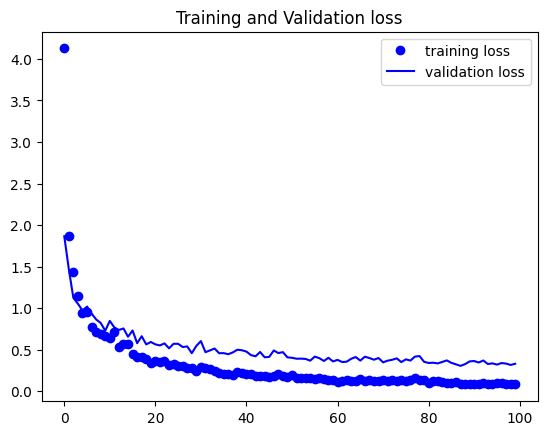

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 2 completed with MAE: 0.6972970962524414
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 5.0946 - mae: 1.7759 - val_loss: 1.7463 - val_mae: 1.0126
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.7282 - mae: 1.0293 - val_loss: 1.6576 - val_mae: 0.9510
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.4930 - mae: 0.9361 - val_loss: 1.3203 - val_mae: 0.8959
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1679 - mae: 0.8315 - val_loss: 1.0685 - val_mae: 0.7769
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9785 - mae: 0.7472 - val_loss: 1.0677 - val_mae: 0.7561
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8268 - mae: 0.6898 - val_loss: 1.0241 - val_mae: 0.7483
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7734 - mae: 0.6571 - val_loss: 1.2106 - val_mae: 0.8160
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8781 - mae: 0.6991 - val_loss: 0.9475 - val_mae: 0.7258
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 

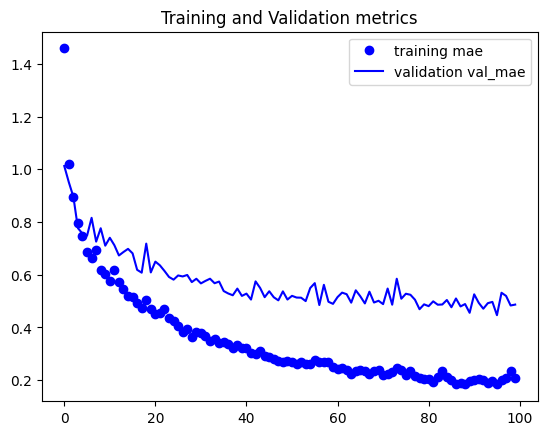

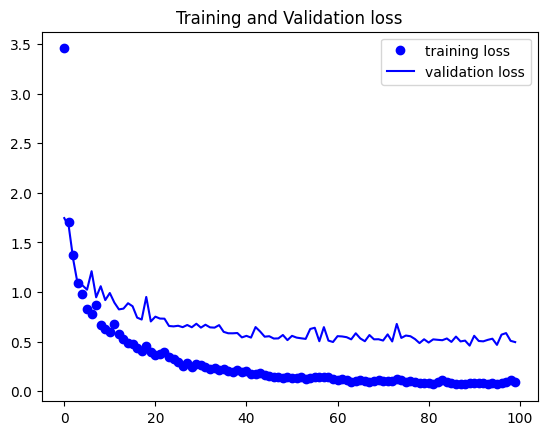

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 3 completed with MAE: 0.25260138511657715
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.3613 - mae: 1.6171 - val_loss: 1.9232 - val_mae: 1.0507
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.7543 - mae: 1.0063 - val_loss: 1.2738 - val_mae: 0.8976
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.4983 - mae: 0.9509 - val_loss: 1.2819 - val_mae: 0.9019
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2741 - mae: 0.8490 - val_loss: 1.0059 - val_mae: 0.7663
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.0144 - mae: 0.7678 - val_loss: 0.9753 - val_mae: 0.7693
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9441 - mae: 0.7310 - val_loss: 0.8920 - val_mae: 0.7113
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8106 - mae: 0.6897 - val_loss: 0.9613 - val_mae: 0.7341
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7344 - mae: 0.6410 - val_loss: 0.8521 - val_mae: 0.7060
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 

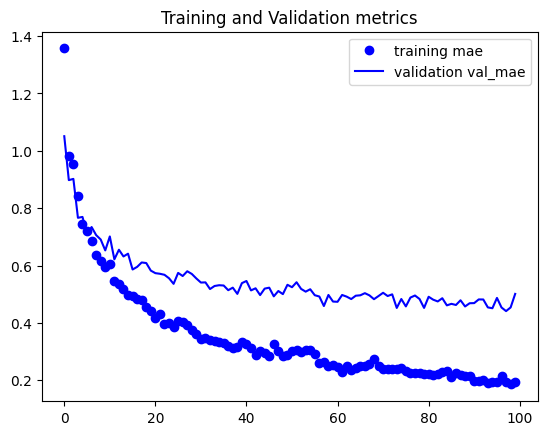

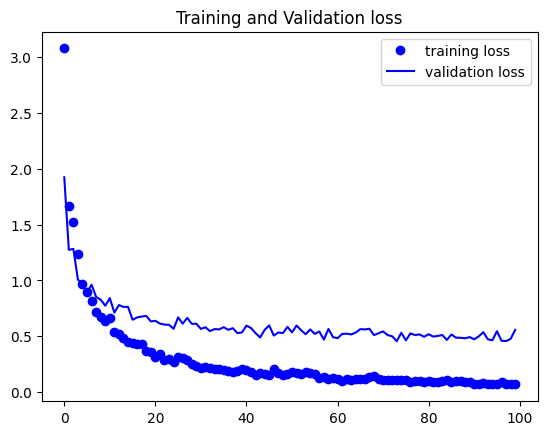

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Fold 4 completed with MAE: 0.26360535621643066
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 7.0690 - mae: 2.1423 - val_loss: 2.6473 - val_mae: 1.3192
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.4479 - mae: 1.2384 - val_loss: 1.5974 - val_mae: 0.9918
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.6493 - mae: 0.9934 - val_loss: 1.2799 - val_mae: 0.9035
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.4323 - mae: 0.9356 - val_loss: 1.1919 - val_mae: 0.8525
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1248 - mae: 0.8126 - val_loss: 1.0350 - val_mae: 0.7956
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.0645 - mae: 0.7933 - val_loss: 1.0339 - val_mae: 0.7697
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.0529 - mae: 0.7835 - val_loss: 1.0513 - val_mae: 0.7672
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8909 - mae: 0.7226 - val_loss: 0.8920 - val_mae: 0.7281
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 

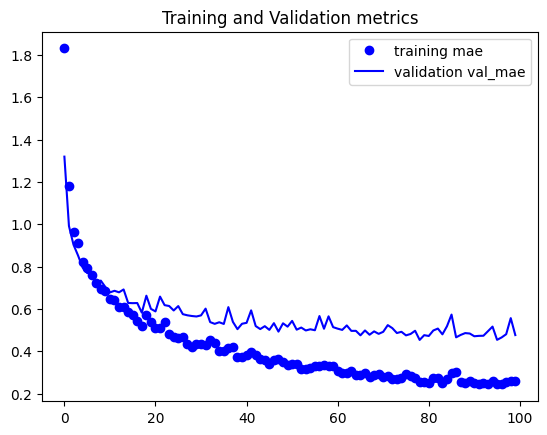

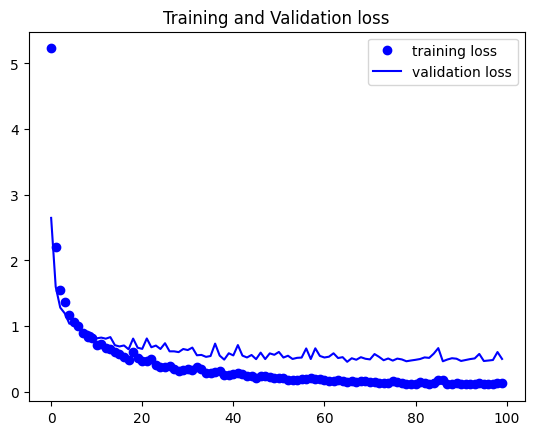

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Fold 5 completed with MAE: 0.34662747383117676
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 4.7197 - mae: 1.6942 - val_loss: 1.6252 - val_mae: 1.0118
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.5521 - mae: 0.9430 - val_loss: 1.2882 - val_mae: 0.8543
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.3251 - mae: 0.8632 - val_loss: 1.1376 - val_mae: 0.8083
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.0579 - mae: 0.7724 - val_loss: 1.0723 - val_mae: 0.7453
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9988 - mae: 0.7408 - val_loss: 0.8098 - val_mae: 0.6491
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7925 - mae: 0.6677 - val_loss: 0.7577 - val_mae: 0.6231
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6217 - mae: 0.5881 - val_loss: 0.8189 - val_mae: 0.6393
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.6405 - mae: 0.5959 - val_loss: 0.7397 - val_mae: 0.6273
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 

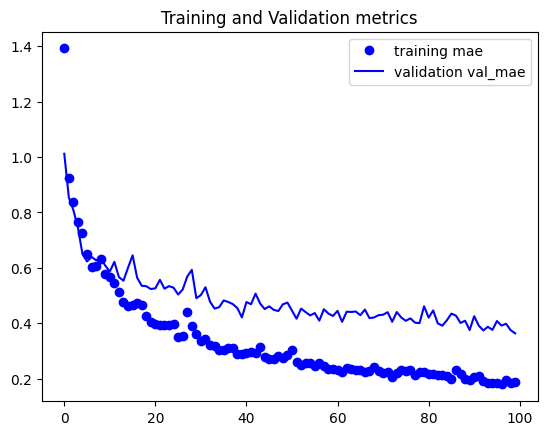

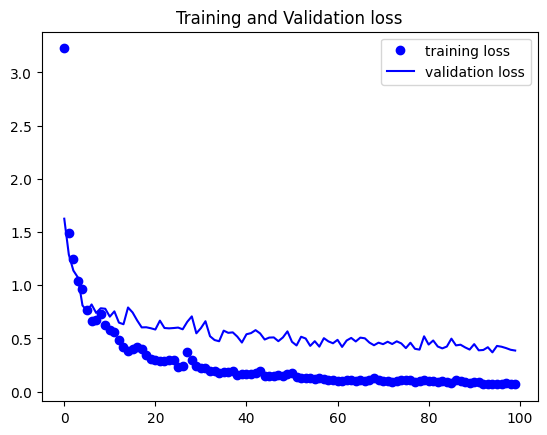

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Fold 6 completed with MAE: 0.6683186292648315
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.6241 - mae: 1.5133 - val_loss: 1.5974 - val_mae: 0.9759
Epoch 2/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.4867 - mae: 0.9175 - val_loss: 1.2965 - val_mae: 0.8433
Epoch 3/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1768 - mae: 0.8071 - val_loss: 1.3326 - val_mae: 0.8529
Epoch 4/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0274 - mae: 0.7544 - val_loss: 0.9802 - val_mae: 0.7236
Epoch 5/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.8227 - mae: 0.6827 - val_loss: 0.8564 - val_mae: 0.6907
Epoch 6/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7238 - mae: 0.6280 - val_loss: 0.8433 - val_mae: 0.6725
Epoch 7/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6743 - mae: 0.5962 - val_loss: 0.6858 - val_mae: 0.6069
Epoch 8/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.5593 - mae: 0.5526 - val_loss: 0.6609 - val_mae: 0.5923
Epoch 9/1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 

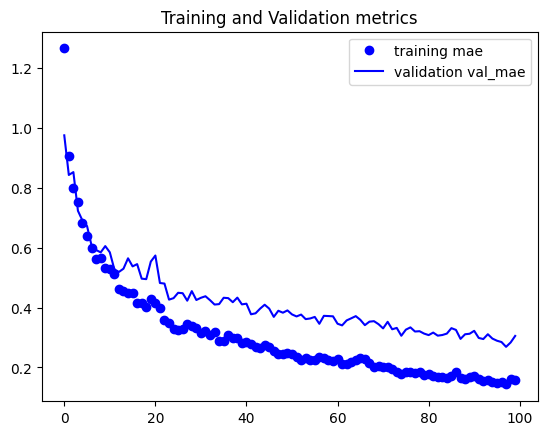

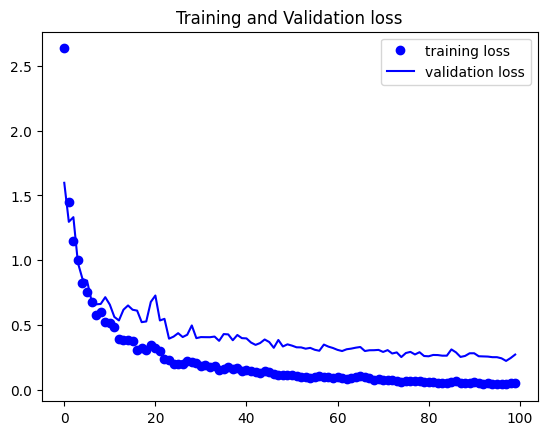

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Fold 7 completed with MAE: 0.9278029799461365
Median Absolute Error for each fold: [0.5683644711971283, 0.6972970962524414, 0.25260138511657715, 0.26360535621643066, 0.34662747383117676, 0.6683186292648315, 0.9278029799461365]


In [17]:
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import median_absolute_error

# Initialize lists to store results
y_test_list = [[] for _ in range(k)]
y_pred_list = [[] for _ in range(k)]
mae_list = []  # To store the MAE for each fold

for i in range(k):
    # Split data into training and test sets
    X_train = X.iloc[train_index[i]]
    X_test = X.iloc[test_index[i]]
    y_train = y.iloc[train_index[i]]
    y_test = y.iloc[test_index[i]]

    # Further split X_train and y_train into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=100, stratify=y_train)

    # Feature standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert transformed arrays back to DataFrames (if necessary)
    X_train = pd.DataFrame(X_train)
    X_val = pd.DataFrame(X_val)
    X_test = pd.DataFrame(X_test)

    # Define the model
    model = Sequential()
    model.add(Dense(1000, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))

    # Compile the model
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])

    # Fit the model
    history = model.fit(
        X_train, y_train,
        batch_size=100,
        epochs=1000,
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks=(early_stopping)
    )

    # Visualize the training and validation MAE
    compare_TV(history, "mae", "val_mae")

    # Make predictions
    y_pred = model.predict(X_test)

    # Save model and scaler
    model.save(f'/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Models/1411_model_fold_{i+1}.keras')
    joblib.dump(scaler, f'/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Models/1411_scaler_fold_{i+1}.pkl')

    # Calculate and store the median absolute error for the fold
    fold_mae = median_absolute_error(y_test, y_pred)
    mae_list.append(fold_mae)

    # Save the test and prediction results for each fold
    y_test_list[i] = y_test
    y_pred_list[i] = y_pred

    print(f"Fold {i+1} completed with MAE: {fold_mae}")

# Print all MAEs
print("Median Absolute Error for each fold:", mae_list)


## Evaluation

In [12]:
for i in range(len(y_test_list)):
    y_test_list[i] = y_test_list[i].values

In [13]:
y_test_tot = []
y_pred_tot = []

for i in range(k):
    y_test_tot.extend(y_test_list[i])
    y_pred_tot.extend(y_pred_list[i])

In [14]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

In [15]:
# result scores

print('DNN')
print('###########################')
print('Med-abs-err: ',round(median_absolute_error(y_test_tot, y_pred_tot),4))
print('Max-err: ',round(max_error(y_test_tot, y_pred_tot),4))
print('R2_score: ',round(r2_score(y_test_tot, y_pred_tot),4))
print('###########################')

DNN
###########################
Med-abs-err:  0.4237
Max-err:  4.9261
R2_score:  0.6563
###########################


## Export model

In [ ]:
import tensorflow as tf

model.save('/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Models/WiCount_FE_DNNR_2days.keras')